## We choose a window of 60 time steps
## We want to learn 48 steps and predict 12 steps.
## Each step = 1 second

In [37]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [8]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 10 time steps
We want to learn 8 steps and predict 2 steps.

In [9]:
window_size = 10
grouped_data = windowing_array(data, window_size)

In [10]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

459720
10
8


### Slice and Split sequence 

In [11]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [12]:
x_train_init.shape, x_test_init.shape

((367776, 10, 8), (91944, 10, 8))

In [13]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [14]:
x_train.shape, y_train.shape

((367776, 8, 8), (367776, 2, 8))

In [15]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(367776, 8, 8)

In [16]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [17]:
y_train.shape

(367776, 2, 2)

In [18]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [19]:
x_test.shape, y_test.shape

((91944, 8, 8), (91944, 2, 8))

In [20]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [21]:
y_test.shape

(91944, 2, 2)

### Model Configuration

In [22]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(8, 8)

In [23]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(2, 2)

In [24]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

4

### Train and evaluate

In [25]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [26]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [27]:
epochs = 5
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_long_2.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
9195/9195 [==============================] - 147s 16ms/step - loss: 322.6078 - mae: 12.3288 - val_loss: 8.1863 - val_mae: 2.0798 - lr: 0.0010
Epoch 2/5
9195/9195 [==============================] - 142s 15ms/step - loss: 248.5757 - mae: 11.2456 - val_loss: 11.2698 - val_mae: 2.4872 - lr: 0.0010
Epoch 3/5
9195/9195 [==============================] - 139s 15ms/step - loss: 246.1839 - mae: 11.1045 - val_loss: 22.5288 - val_mae: 3.5821 - lr: 0.0010
Epoch 4/5
9195/9195 [==============================] - 130s 14ms/step - loss: 245.5405 - mae: 11.0120 - val_loss: 12.5754 - val_mae: 2.4016 - lr: 0.0010
Epoch 5/5
9195/9195 [==============================] - 127s 14ms/step - loss: 245.1427 - mae: 11.0255 - val_loss: 16.3717 - val_mae: 2.9964 - lr: 0.0010


In [ ]:
#model.summary()

In [28]:
model = keras.models.load_model("best_model_long_2.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2874/2874 [==============================] - 11s 4ms/step - loss: 7.9934 - mae: 2.1028
Test accuracy 2.1027514934539795
Test loss 7.993389129638672


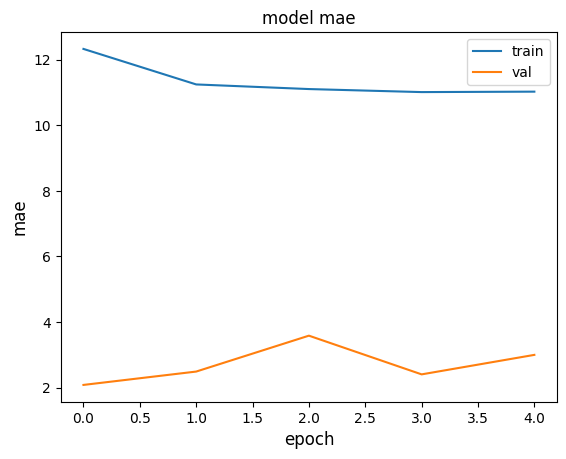

In [29]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [30]:
predictions = model.predict(x_test)

2874/2874 [==============================] - 10s 4ms/step


In [31]:
predictions.shape

(91944, 2, 2)

Visualize some few predictions


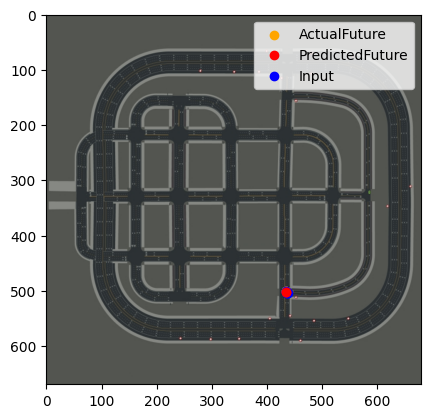

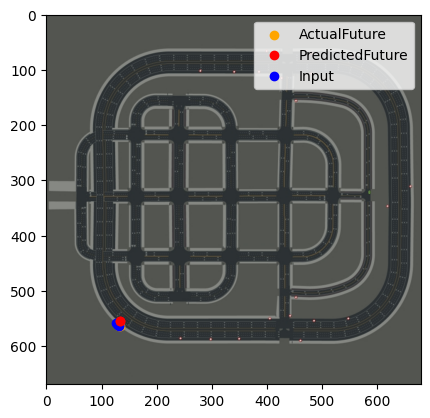

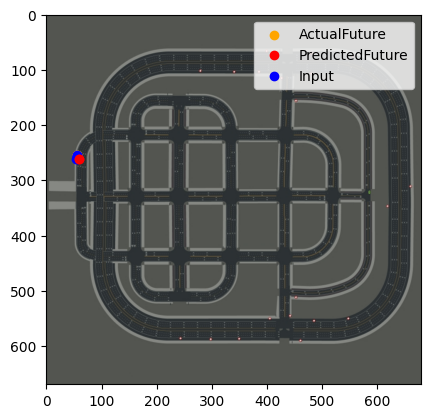

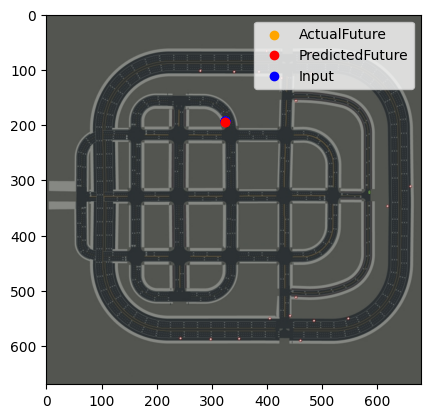

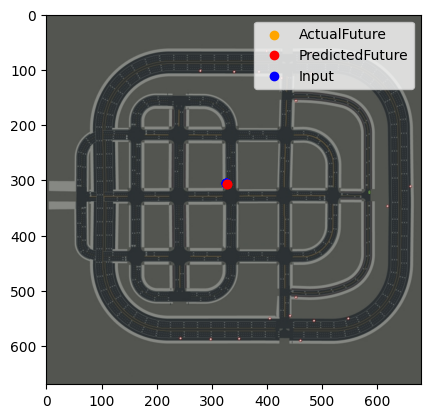

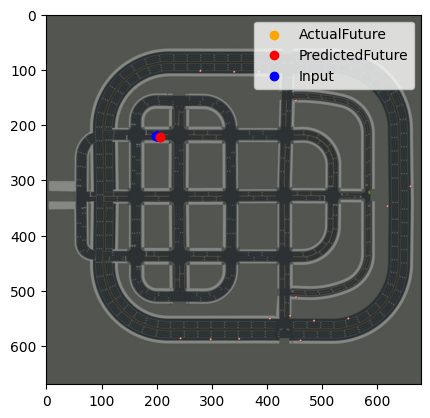

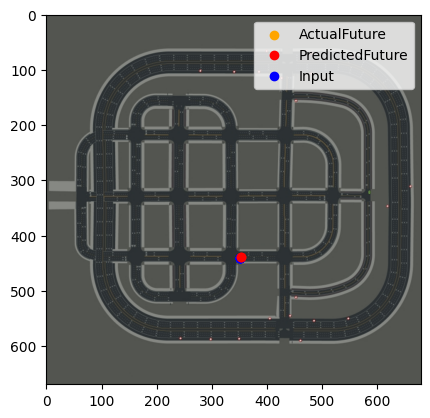

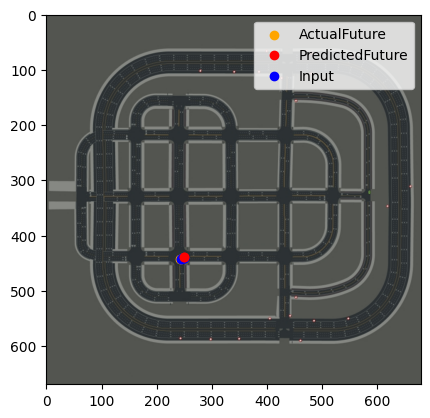

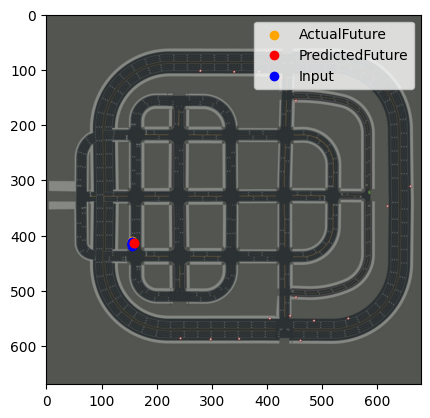

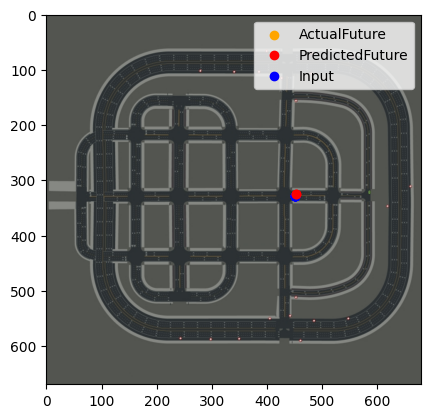

In [32]:
import random
from configs.utils_2 import plot_pred, plot_pred2


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test[:, :, :2]))
        plot_pred2(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

In [33]:
from explainers.explainer import BlackBoxWrapper, ITPFExplainer

blackbox = BlackBoxWrapper(model=model, isMultivariate=True)
explainer = ITPFExplainer()
explainer.fit_exp(
    model=blackbox, 
    x=x_train, 
    y=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], 
    class_names=['pos.x', 'pos.y'],
    feature_nr=8,
    feature_pred_nr=2
)

In [34]:
y=x_test[0]

In [35]:
y.shape

(8, 8)

In [38]:
baseline_tab = explainer.baseline_extra(y)

In [39]:
baseline_tab.shape

(8, 8)

In [42]:
predictions[0]

array([[32.214455, 69.749   ],
       [32.226738, 69.70606 ]], dtype=float32)

In [40]:
y

array([[ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  2.60932360e-06,  2.00000000e+00,
        -1.68420540e-08,  1.00000000e+00],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  1.71663107e-07,  2.00000000e+00,
         1.04528449e-01,  9.94521897e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  8.92640017e-07,  2.00000000e+00,
         2.07911680e-01,  9.78147603e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  1.64795057e-06,  2.00000000e+00,
         3.09016987e-01,  9.51056519e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  4.26028053e-06,  2.00000000e+00,
         4.06736638e-01,  9.13545460e-01],
       [ 3.22074852e+01,  6.97024384e+01, -1.13048935e-02,
        -1.18837438e-01,  0.00000000e+00,  2.00000000e+00,
         4.99999985e-01,  8.66025412e-01],
       [ 3.22074852e+01,  6.970243

In [41]:
baseline_tab

array([[ 1.35759844e+02,  1.62300696e+02,  3.65798220e-02,
         1.44011702e-01,  2.17057750e-06, -1.35852297e+00,
        -7.80438012e-01, -2.47215073e+00],
       [-6.05898014e+01,  5.60075688e+01,  1.44434146e-02,
        -4.52635944e-01,  1.20861361e-06, -9.80119535e+00,
        -1.11006739e-01, -9.25768502e-01],
       [-1.59140959e+02, -1.43113354e+02, -3.56119677e-02,
        -2.35232666e-01,  1.96011349e-06,  1.38604066e+01,
         2.52542149e-01, -4.43341807e-01],
       [-1.73357157e+02,  1.99372925e+02, -3.14281656e-02,
        -1.00109222e+00,  1.91559594e-06, -2.68913517e+00,
         6.08559266e-01,  7.88181504e-01],
       [-2.03551463e+02,  6.77011169e+01, -7.79430147e-03,
         5.75931658e-01,  4.22506030e-06, -5.42969394e+00,
        -2.13566231e-01, -4.78513358e+00],
       [-5.72988905e+01, -1.42887794e+00, -5.47257137e-02,
         1.23879100e-01,  5.10095866e-07,  8.32145140e+00,
         4.01507602e-01, -9.65182312e-01],
       [-7.43299256e+01,  1.069571

In [43]:
import numpy as np
import itertools
import sys

In [44]:
from scipy.special import comb
import math

def compute_weight(total_features, subset_size):
    """
    Computes the weight for subsets of a given size in the context of Shapley values.
    
    Parameters:
    - total_features: Total number of features (|N|).
    - subset_size: Size of the subset including the feature (|S|).
    
    Returns:
    - The weight for the subset.
    """
    return (math.factorial(subset_size - 1) * math.factorial(total_features - subset_size)) / math.factorial(total_features)

# Example usage
total_features = 8  # Total number of features
subset_size = 1  # Size of the subset including the feature of interest

weight = compute_weight(total_features, subset_size)
print(f"Weight for subset of size {subset_size} (out of {total_features}): {weight}")

Weight for subset of size 1 (out of 8): 0.125


In [45]:
from itertools import product


def create_mask(feature_num):
    mask = np.array(list(product(range(2), repeat=feature_num)))
    mask = mask[~np.all(mask == 0, axis=1)]
    mask = mask[~np.all(mask == 1, axis=1)]
  
    return mask

In [82]:
def value_function(feature, feature_num, y, model):
    # create array mask
    mask=create_mask(feature_num)

    # configuration and baseline
    marginal_contribution = []
    average_contribution = []
    data = y
    baseline_tab = explainer.baseline_extra(data)
    n_features = data.shape[1]
    baseline_pred = model.predict_2Dto3D(baseline_tab)
    original_pred = model.predict_2Dto3D(data)

    # compute marginal contribution for baseline {feature} - {}
    weight = compute_weight(feature_num, 1)
    pred = weight*(original_pred - baseline_pred)
    marginal_contribution.append(pred)
    # compute marginal contribution

    for item in mask:
        # Initialize arrays as copies of data and baseline_tab
        without_feature = baseline_tab.copy()
        with_feature = baseline_tab.copy()
        number_of_feature_masked = 0
        
        # Iterate over each element in the mask
        for i, use_data in enumerate(item):
            if use_data:
                without_feature[:, i] = data[:, i]
                with_feature[:, i] = data[:, i]
                number_of_feature_masked = number_of_feature_masked + 1

        # Include the feature
        with_feature[:, feature] = data[:, feature]
        number_of_feature_masked = number_of_feature_masked + 1
        weight = compute_weight(feature_num, number_of_feature_masked)
       

        # compute marginal contribution
        pred_without_feature = model.predict_2Dto3D(without_feature)
        pred_with_feature = model.predict_2Dto3D(with_feature)
        pred = weight*(pred_with_feature - pred_without_feature)
        
        marginal_contribution.append(pred)
        #print(marginal_contribution)
    
    # compute the average contribution
    marginal_contribution_combined = np.concatenate(marginal_contribution, axis=0)
    print(marginal_contribution_combined)
    average_contribution = np.mean(marginal_contribution_combined, axis=0)
    return average_contribution


In [78]:
def shap_values_multivariate(model, y):
    # step 1: Get the baseline and configuration
    n_features = y.shape[1]
    shapley_values = []
    # step 2: Compute the shapeley values for each feature
    for feature in range(n_features):
        s_value = value_function(feature, n_features, y, model)
        print("Feature ", feature, " values: ", s_value)
        # Load values
        shapley_values.append(s_value)
            
    return shapley_values

In [84]:
s = shap_values_multivariate(blackbox, y)

(1, 8, 8)
1/1 [==============================] - 0s 13ms/step
(1, 8, 8)
1/1 [==============================] - 0s 14ms/step
(1, 8, 8)
1/1 [==============================] - 0s 17ms/step
(1, 8, 8)
1/1 [==============================] - 0s 16ms/step
(1, 8, 8)
1/1 [==============================] - 0s 18ms/step
(1, 8, 8)
1/1 [==============================] - 0s 17ms/step
(1, 8, 8)
1/1 [==============================] - 0s 18ms/step
(1, 8, 8)
1/1 [==============================] - 0s 16ms/step
(1, 8, 8)
1/1 [==============================] - 0s 17ms/step
(1, 8, 8)
1/1 [==============================] - 0s 18ms/step
(1, 8, 8)
1/1 [==============================] - 0s 17ms/step
(1, 8, 8)
1/1 [==============================] - 0s 18ms/step
(1, 8, 8)
1/1 [==============================] - 0s 17ms/step
(1, 8, 8)
1/1 [==============================] - 0s 18ms/step
(1, 8, 8)
1/1 [==============================] - 0s 19ms/step
(1, 8, 8)
1/1 [==============================] - 0s 19ms/step
(1, 8, 8

In [127]:
# process shap values
timestep1 = []
timestep2 = []
for values in range(len(s)):
    v = np.array(s)
    #print(v[values][0])
    timestep1.append(v[values][0])
    #print(v[values][1])
    timestep2.append(v[values][1])

In [129]:
timestep1 = np.array(timestep1)
timestep2 = np.array(timestep2)


[-0.43209052 -0.02783286 -0.05102491 -0.05131936 -0.05103186 -0.05026646
 -0.05111127 -0.05125251]


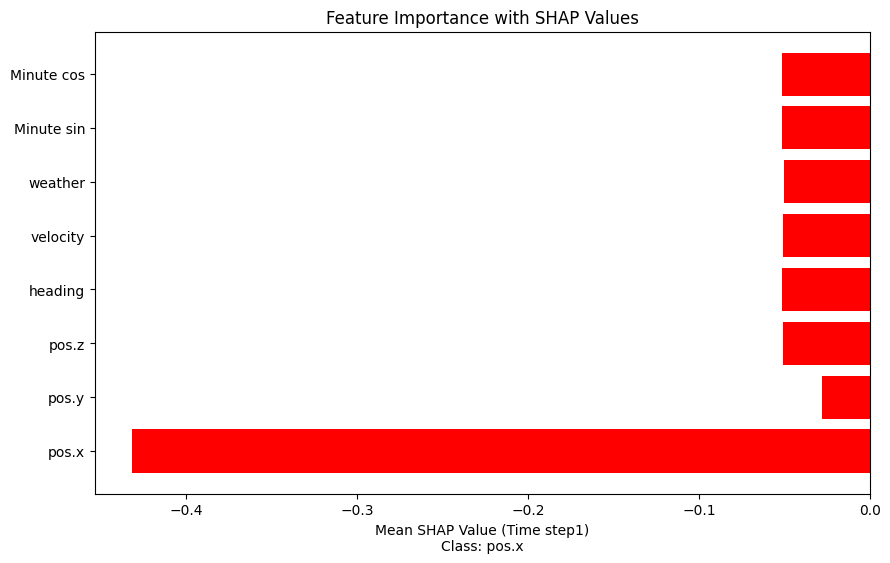

In [137]:
num_features = 8
shap_values = timestep1[:, 0]  # Your actual Shapley values
feature_names = ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"]
print(shap_values)
# Determine bar colors based on the sign of the mean Shapley values
bar_colors = ['red' if x < 0 else 'blue' for x in shap_values]

# Plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, shap_values, align='center', color=bar_colors)
plt.yticks(y_pos, feature_names)
plt.xlabel('Mean SHAP Value (Time step1)\nClass: pos.x')
plt.title('Feature Importance with SHAP Values')
plt.show()

[-0.43238956 -0.02830952 -0.0511116  -0.05140794 -0.05111859 -0.05035142
 -0.05119814 -0.05134169]


Text(0.5, 1.0, 'Feature Importance with SHAP Values')

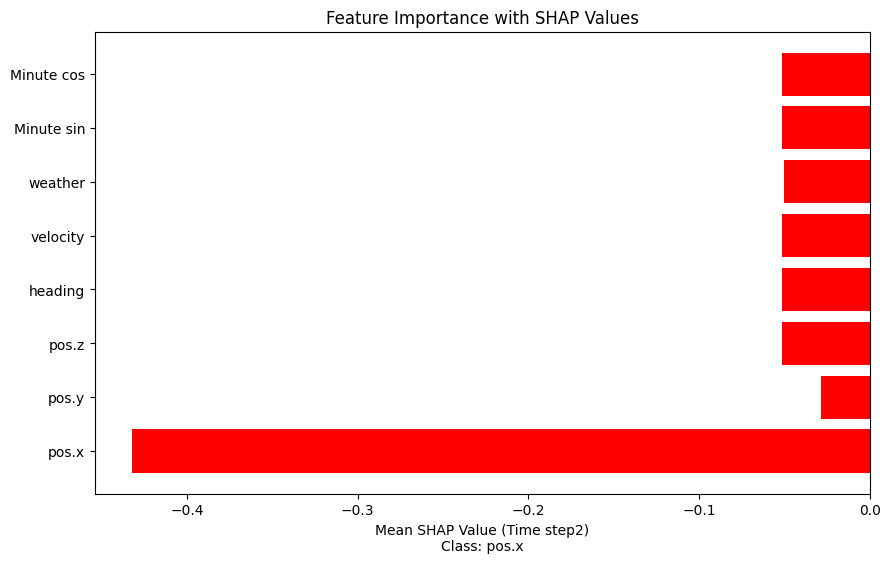

In [136]:
num_features = 8
shap_values = timestep2[:, 0]  # Your actual Shapley values
feature_names = ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"]
print(shap_values)
# Determine bar colors based on the sign of the mean Shapley values
bar_colors = ['red' if x < 0 else 'blue' for x in shap_values]

# Plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, shap_values, align='center', color=bar_colors)
plt.yticks(y_pos, feature_names)
plt.xlabel('Mean SHAP Value (Time step2)\nClass: pos.x')
plt.title('Feature Importance with SHAP Values')

[-0.12591714 -0.93197423 -0.11753957 -0.11761289 -0.11754481 -0.11833501
 -0.11760972 -0.1163651 ]


Text(0.5, 1.0, 'Feature Importance with SHAP Values')

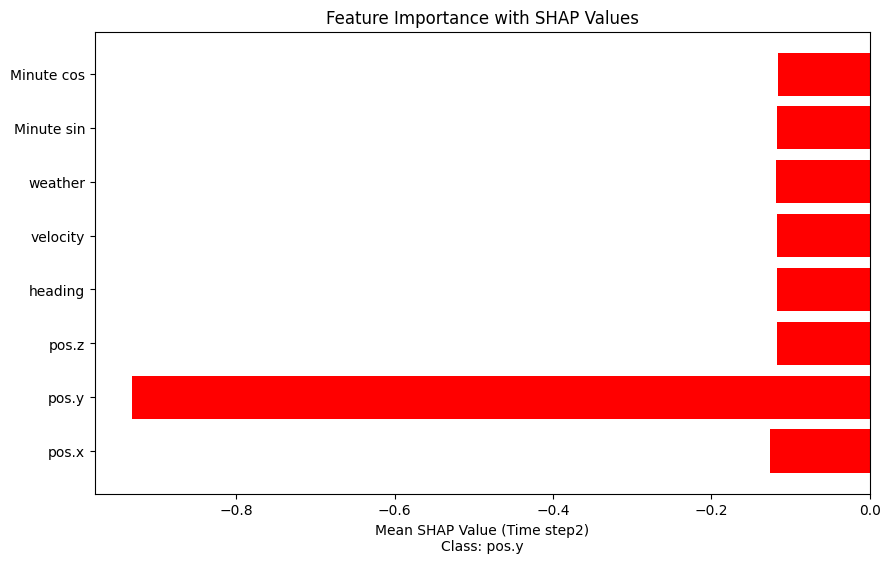

In [138]:
num_features = 8
shap_values = timestep1[:, 1]  # Your actual Shapley values
feature_names = ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"]
print(shap_values)
# Determine bar colors based on the sign of the mean Shapley values
bar_colors = ['red' if x < 0 else 'blue' for x in shap_values]

# Plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, shap_values, align='center', color=bar_colors)
plt.yticks(y_pos, feature_names)
plt.xlabel('Mean SHAP Value (Time step2)\nClass: pos.y')
plt.title('Feature Importance with SHAP Values')

[-0.12565964 -0.93186206 -0.11749941 -0.11757305 -0.11750463 -0.11830187
 -0.11756961 -0.11633031]


Text(0.5, 1.0, 'Feature Importance with SHAP Values')

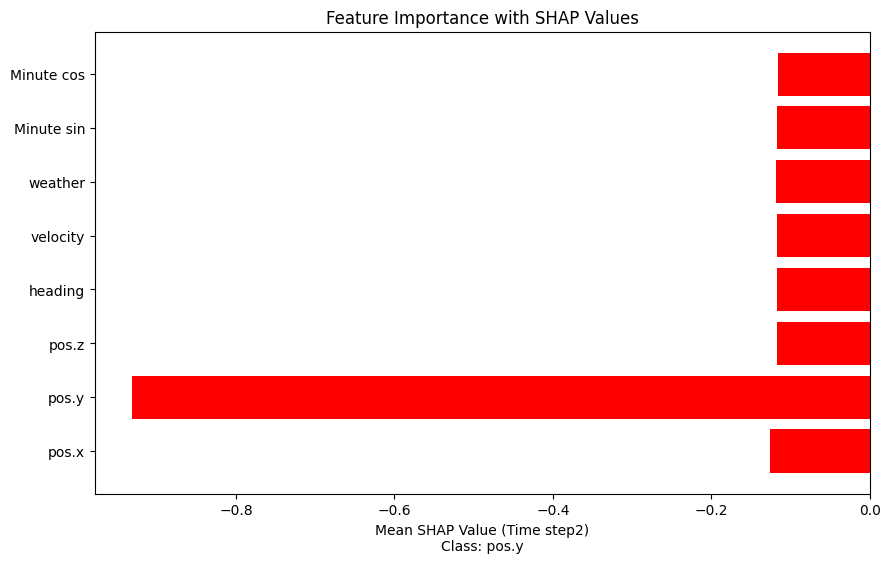

In [139]:
num_features = 8
shap_values = timestep2[:, 1]  # Your actual Shapley values
feature_names = ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"]
print(shap_values)
# Determine bar colors based on the sign of the mean Shapley values
bar_colors = ['red' if x < 0 else 'blue' for x in shap_values]

# Plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, shap_values, align='center', color=bar_colors)
plt.yticks(y_pos, feature_names)
plt.xlabel('Mean SHAP Value (Time step2)\nClass: pos.y')
plt.title('Feature Importance with SHAP Values')